In [34]:
import os
import sys
import re

import numpy as np
import pandas as pd
import seaborn as sns
import math
import random

import tools as tl
from coralModel import Reef, Organism, Ocean

import matplotlib.pyplot as plt
import matplotlib.colors as clt
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [38]:
## Function to pull info from image
def reef_from_image(image, threshold, number_of_rows, number_of_columns):
    
    Moorea = Reef()
    count=0
    for i in range(0, number_of_rows):
        for j in range(0, number_of_columns):
            
            node = Organism(type=image[i,j], 
                            location=[i,j], 
                            ID=count)
            Moorea.append(node)
            count = count + 1
    Moorea.generate_graph(1.45)
    #densities = np.array([Moorea.nodes[n].neighbors[0] for n,val in enumerate(Moorea.nodes)])
    #values = [Moorea.nodes[n].type for n,val in enumerate(Moorea.nodes)]
    return(Moorea)

def extract_neighbors(Moorea, node, count):
    if count == 0:
        neighbors = 0
    else:
        neighbors = np.array([Moorea.nodes[n].neighbors/
                              Moorea.nodes[n].neighbors.sum()
                              for n,val in enumerate(Moorea.nodes)
                              if Moorea.nodes[n].type == node]).mean(axis=0)
    return(neighbors)

def prep_image(df, simulation, time):    
    image = df[(df['time']==time)&(df['simulation']==simulation)]['image']
    image = np.genfromtxt([image.values[0].replace('[', '').replace(']', '')])
    image = np.reshape(image, (25,25))
    return(image)

def annotated_image_plots(threshold=1.45, name='example', 
                          simulation=1, times=[0,10]):
    
    data=df[df['neighborhood_threshold']==int(threshold*100)]    
    fig, ax = plt.subplots(1, len(times), figsize=(5,5)) 

    for index in range(0, len(times)):

        image = prep_image(data,simulation,times[index])
        reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
        coral_count = np.count_nonzero(image==0)
        neighbors = extract_neighbors(reef, int(0), coral_count)
        ax[index].imshow(image, cmap=cmap, norm=norm)
        ax[index].set_xticks([])
        ax[index].set_title('Time = ' + str(int(times[index])))
        ax[index].set_xlabel('coral_percent: ' 
                             + str(round(coral_count/(number_of_rows*number_of_columns), 2))
                             + '\n \n' + 'neighbors: ' + 
                             '\n coral_coral: ' +str(round(neighbors[0],3))+ 
                             '\n coral_turf: ' + str(round(neighbors[1],3)) +
                             '\n coral_macro: ' + str(round(neighbors[2],3)))
        ax[index].axes.yaxis.set_visible(False)        
        ax[index].set_frame_on(False)
    #fig.suptitle(title)
    fig.subplots_adjust(wspace=0.2, top=.75)
    plt.savefig(path + name + extension, dpi=400)
    
## For plots
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p] 

def create_reef(simulation): 
    
    Moorea = Reef()
    count = 0
    for i in range(0, number_of_rows): 
        for j in range(0, number_of_columns):
            if grid_option == 3: ##for threshold plotting
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    return(Moorea)

In [39]:
path = './figures/paper/3_threshold_change/'
extension = '.png'

top_directory = "./output/" #os.getcwd()
files, runs = tl.view_runs(top_directory)

## Threshold Setup

In [4]:
thresholds = [1.45, 36]
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
middle_node =  68 #27 #round(rows*rows/2)
simulation = 19

threshold_images = []
grid_option = 3 #specifically for plotting thresholds
reef = create_reef(simulation)

for threshold in thresholds:
    
    reef.generate_graph(threshold)
    neighbors = reef.graph[middle_node]
    
    for neighbor in neighbors:
        reef.nodes[neighbor].type = 1 
        
    reef.nodes[middle_node].type = 2
    
    reef_types = np.array([reef.nodes[i].type for i,val in enumerate(reef.nodes)], dtype=float)   
    threshold_images.append(np.reshape(reef_types, (number_of_rows, number_of_columns)))

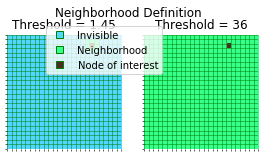

In [5]:
name = 'neighborhood_definition'

def neighborhood_visualization():
    titles = ['Threshold = '+str(thresholds[0]), 
              'Threshold = '+str(thresholds[1])]
    levels = [0, 1, 2]
    #colors = ['#f0f0f0', '#94b09e', '#30424f']
    colors = ['#51D6FF', '#37FF8B', '#522B29']
    legend_lables = ['Invisible', 'Neighborhood', 'Node of interest']
    cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3))  
    fig.suptitle('Neighborhood Definition')

    for index, value in enumerate(threshold_images):
        ax[index].imshow(value, cmap=cmap, norm=norm)#, interpolation='none', aspect='equal') 
        ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].set_frame_on(False)
        ax[index].grid(color='green', linestyle='-', linewidth=.5, which='minor')
        ax[index].set_title(titles[index])

    patches = [mpatches.Patch(facecolor=colors[i], edgecolor="green", label=legend_lables[i]) for i in levels]
    fig.legend(handles=patches, bbox_to_anchor=(.50, .60), borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels})
    fig.subplots_adjust(top=1.05)
    plt.savefig(path + name + extension, dpi=200)
    plt.show()


neighborhood_visualization()

## Output Plots

In [6]:
colors =['#EE8382', '#508991', '#172A3A']
species_palette = sns.set_palette(sns.color_palette(colors))

levels = [0, 1, 2]
legend_keys = ['Coral', 'Turf', 'Macroalgae']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')


## Grazing = .51

In [7]:
grazing = 51
subset = runs[(runs['number_of_timesteps']==3000)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)]
subset

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
2,25,25,0,51,1100,33,33,10,40,20,75,3000,10,100,2
4,25,25,0,51,500,33,33,10,40,20,75,3000,10,100,4
5,25,25,0,51,145,33,33,10,40,20,75,3000,10,100,5
7,25,25,0,51,3600,33,33,10,40,20,75,3000,10,100,7


In [8]:
df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')

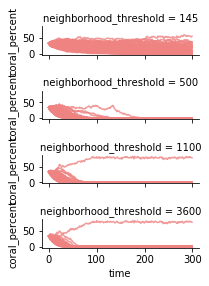

In [9]:
variable='coral_percent'
sns.relplot(x="time", y=variable, 
            units="simulation", estimator=None, 
            data=df, kind="line",
            row='neighborhood_threshold',
            height=1, alpha=.8, aspect=3)

In [10]:
df_to_melt_145 = df[df['neighborhood_threshold']==145][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_145 = pd.melt(df_to_melt_145, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_500 = df[df['neighborhood_threshold']==500][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_500 = pd.melt(df_to_melt_500, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_1100 = df[df['neighborhood_threshold']==1100][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_1100 = pd.melt(df_to_melt_1100, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_3600 = df[df['neighborhood_threshold']==3600][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_3600 = pd.melt(df_to_melt_3600, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

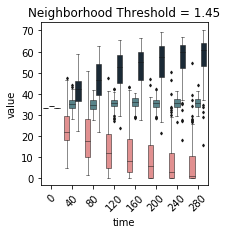

In [11]:
name='boxplot_temporal_evolution_145_grazing_' + str(grazing)

times = [0,40, 80, 120, 160, 200, 240, 280]

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_145[df_melted_145['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 1.45')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

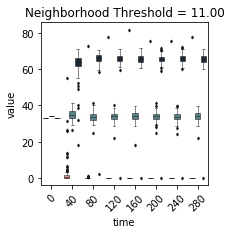

In [12]:
name='boxplot_temporal_evolution_1100_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
            data=df_melted_1100[df_melted_1100['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))


plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 11.00')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

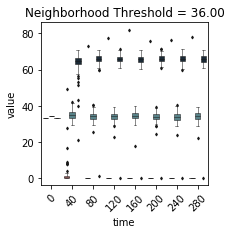

In [13]:
name='boxplot_temporal_evolution_3600_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_3600[df_melted_3600['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.title('Neighborhood Threshold = 36.00')
plt.legend([],[], frameon=False)
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

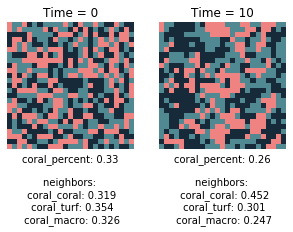

In [40]:
threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

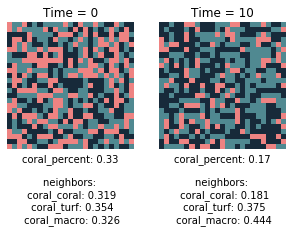

In [41]:
threshold = 36
name = 'early_spatial_evolution_images_3600_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

## Grazing = .54

In [42]:
grazing = 54
subset = runs[(runs['number_of_timesteps']==3000)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)]
subset

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
11,25,25,0,54,1100,33,33,10,40,20,75,3000,10,100,11
12,25,25,0,54,500,33,33,10,40,20,75,3000,10,100,12
13,25,25,0,54,145,33,33,10,40,20,75,3000,10,100,13
14,25,25,0,54,3600,33,33,10,40,20,75,3000,10,100,14


In [43]:
df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')

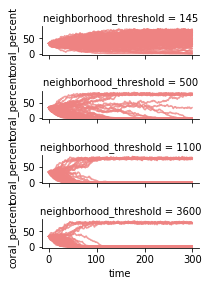

In [44]:
variable='coral_percent'
sns.relplot(x="time", y=variable, 
            units="simulation", estimator=None, 
            data=df, kind="line",
            row='neighborhood_threshold',
            height=1, alpha=.8, aspect=3)

In [45]:
df_to_melt_145 = df[df['neighborhood_threshold']==145][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_145 = pd.melt(df_to_melt_145, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_500 = df[df['neighborhood_threshold']==500][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_500 = pd.melt(df_to_melt_500, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_1100 = df[df['neighborhood_threshold']==1100][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_1100 = pd.melt(df_to_melt_1100, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_3600 = df[df['neighborhood_threshold']==3600][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_3600 = pd.melt(df_to_melt_3600, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

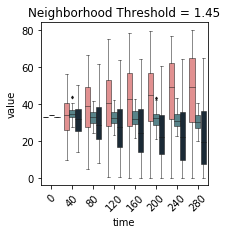

In [46]:
name='boxplot_temporal_evolution_145_grazing_' + str(grazing)

times = [0,40, 80, 120, 160, 200, 240, 280]

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_145[df_melted_145['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 1.45')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

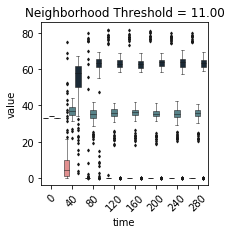

In [47]:
name='boxplot_temporal_evolution_1100_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
            data=df_melted_1100[df_melted_1100['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))


plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 11.00')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

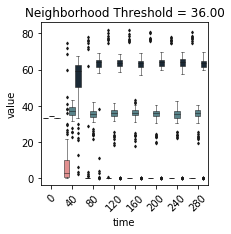

In [48]:
name='boxplot_temporal_evolution_3600_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_3600[df_melted_3600['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.title('Neighborhood Threshold = 36.00')
plt.legend([],[], frameon=False)
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

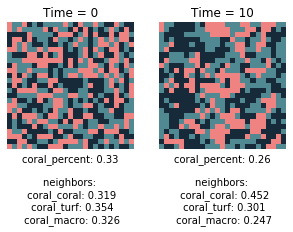

In [49]:
threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

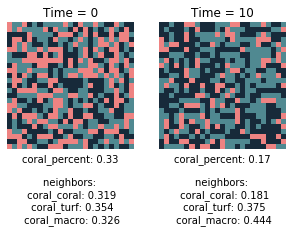

In [50]:
threshold = 36
name = 'early_spatial_evolution_images_3600_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

______

### Additional Threshold Values

____

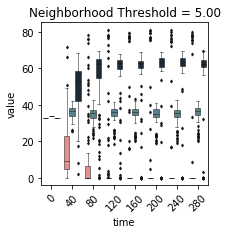

In [41]:
name='boxplot_temporal_evolution_500_grazing_' + str(grazing)

plt.figure(figsize=(3,3))

fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_500[df_melted_500['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 5.00')
#ax._legend.remove()
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")